In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sns
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import PIL.Image
import PIL
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
     
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        #Empty Image and Labels list
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:03<00:00, 79.07it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.20it/s]


In [7]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [8]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [9]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [10]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

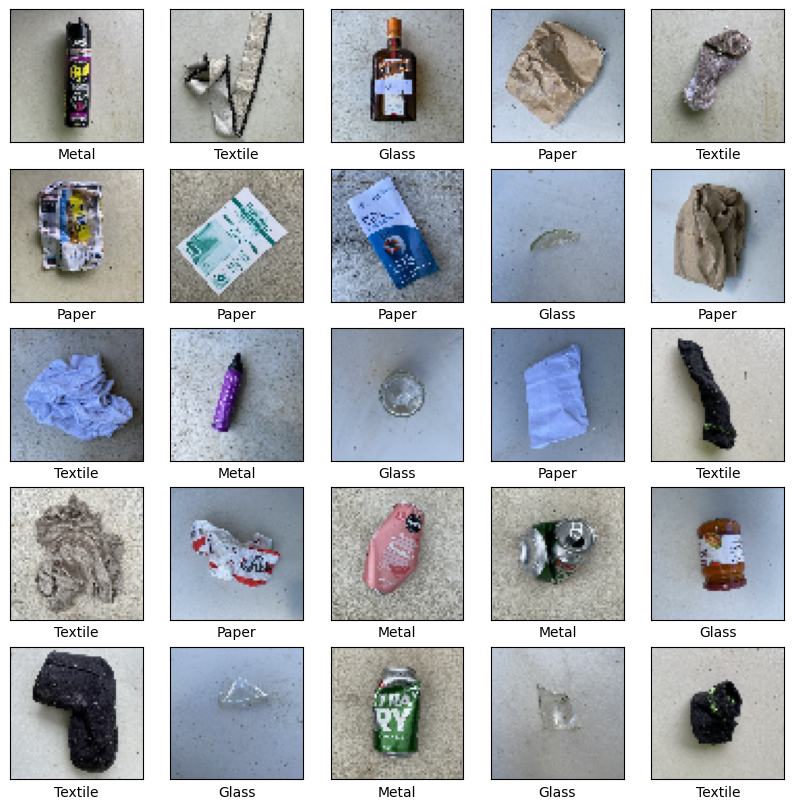

In [11]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
#Sequential Model 1
# Experience 3 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.005), activation = 'relu'),                                                      
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,708 (2.08 MB)

 Trainable params: 544,516 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [13]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 300,164 (1.15 MB)

 Trainable params: 299,460 (1.14 MB)

 Non-trainable params: 704 (2.75 KB)

In [14]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (5,5), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 5
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.005), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 236,452 (923.64 KB)

 Trainable params: 235,876 (921.39 KB)

 Non-trainable params: 576 (2.25 KB)

In [15]:
# Add callbacks to save the model weight with best accuracy during training

#import ModelCheckpoint package
#from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [16]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [17]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

In [18]:
#Learning rate scheduler for Model 1 and 2

def scheduler2(epoch, lr):
    if epoch <= 45:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback2 = LearningRateScheduler(scheduler2, verbose=1)

In [19]:
# Set number of epochs

epochs = 150
batch_size = 64

In [20]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback1, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2024-11-09 13:15:22.511966

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3927 - loss: 9.3320
Epoch 1: val_accuracy improved from -inf to 0.37037, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4013 - loss: 9.1383 - val_accuracy: 0.3704 - val_loss: 6.3604 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5658 - loss: 5.8118
Epoch 2: val_accuracy did not improve from 0.37037
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5748 - loss: 5.7813 - val_accuracy: 0.3611 - val_loss: 5.7705 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6971 - loss: 5.0088
Epoch 3: val_accuracy d

Epoch 20/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9196 - loss: 1.1080
Epoch 20: val_accuracy did not improve from 0.37037
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9196 - loss: 1.1084 - val_accuracy: 0.2639 - val_loss: 5.3452 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 21/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9224 - loss: 1.1028
Epoch 21: val_accuracy did not improve from 0.37037
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9201 - loss: 1.1070 - val_accuracy: 0.2639 - val_loss: 6.0738 - learning_rate: 0.0015

Epoch 22: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 22/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9096 - loss: 1.1182
Epoch 22: val_accuracy did not improve from 0.37037
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9101 - loss: 1.1171 - val_accuracy: 0.3333 - val_loss: 5.3627 - learning_rate: 0.0015

Ep

Epoch 39/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9813 - loss: 0.5888
Epoch 39: val_accuracy did not improve from 0.47222
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9810 - loss: 0.5890 - val_accuracy: 0.3194 - val_loss: 3.2128 - learning_rate: 9.9513e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009453740960452705.
Epoch 40/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9748 - loss: 0.5920
Epoch 40: val_accuracy did not improve from 0.47222
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9752 - loss: 0.5920 - val_accuracy: 0.4398 - val_loss: 2.7354 - learning_rate: 9.4537e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0008981053746538237.
Epoch 41/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9744 - loss: 0.5807
Epoch 41: val_accuracy did not improve from 0.47222
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9743 - loss: 0.5812 - val_accuracy: 0.4537 - val_loss: 2.7601 - learning_rate: 


Epoch 57: LearningRateScheduler setting learning rate to 0.00039528009365312754.
Epoch 57/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9924 - loss: 0.3445
Epoch 57: val_accuracy did not improve from 0.75000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9926 - loss: 0.3443 - val_accuracy: 0.7361 - val_loss: 1.0796 - learning_rate: 3.9528e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003755161000299267.
Epoch 58/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9906 - loss: 0.3472
Epoch 58: val_accuracy did not improve from 0.75000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9908 - loss: 0.3461 - val_accuracy: 0.7315 - val_loss: 1.1340 - learning_rate: 3.7552e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00035674029641086236.
Epoch 59/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9933 - loss: 0.3342
Epoch 59: val_accuracy improved from 0.75000 to 0.77315, saving model to C:/Mani/ModelCheckpoint/model

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9989 - loss: 0.2662
Epoch 75: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9989 - loss: 0.2662 - val_accuracy: 0.7870 - val_loss: 0.8044 - learning_rate: 1.5701e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00014916037034709006.
Epoch 76/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9955 - loss: 0.2656
Epoch 76: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9956 - loss: 0.2653 - val_accuracy: 0.7731 - val_loss: 0.8180 - learning_rate: 1.4916e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00014170235735946334.
Epoch 77/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9980 - loss: 0.2654
Epoch 77: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9978 - loss: 0.2647 - val_accuracy: 0.7778 - val_loss: 0.7706 - learning_rate: 1.4170e-04


Epoch 94/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9989 - loss: 0.2308
Epoch 94: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9989 - loss: 0.2311 - val_accuracy: 0.7963 - val_loss: 0.7373 - learning_rate: 5.9249e-05

Epoch 95: LearningRateScheduler setting learning rate to 5.628619710478233e-05.
Epoch 95/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9974 - loss: 0.2307
Epoch 95: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9976 - loss: 0.2311 - val_accuracy: 0.8056 - val_loss: 0.7306 - learning_rate: 5.6286e-05

Epoch 96: LearningRateScheduler setting learning rate to 5.3471887076739216e-05.
Epoch 96/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.2323
Epoch 96: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.2325 - val_accuracy: 0.7870 - val_loss: 0.7294 - learning_rate:


Epoch 113: LearningRateScheduler setting learning rate to 2.2357684792950748e-05.
Epoch 113/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.2270
Epoch 113: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.2273 - val_accuracy: 0.8056 - val_loss: 0.7146 - learning_rate: 2.2358e-05

Epoch 114: LearningRateScheduler setting learning rate to 2.1239800207695226e-05.
Epoch 114/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9994 - loss: 0.2294
Epoch 114: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9994 - loss: 0.2294 - val_accuracy: 0.8009 - val_loss: 0.7174 - learning_rate: 2.1240e-05

Epoch 115: LearningRateScheduler setting learning rate to 2.017781080212444e-05.
Epoch 115/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9989 - loss: 0.2255
Epoch 115: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step -


Epoch 132: LearningRateScheduler setting learning rate to 8.436753205387504e-06.
Epoch 132/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9996 - loss: 0.2219
Epoch 132: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9995 - loss: 0.2219 - val_accuracy: 0.8102 - val_loss: 0.7111 - learning_rate: 8.4368e-06

Epoch 133: LearningRateScheduler setting learning rate to 8.014915329113137e-06.
Epoch 133/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.2184
Epoch 133: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 0.2184 - val_accuracy: 0.8102 - val_loss: 0.7108 - learning_rate: 8.0149e-06

Epoch 134: LearningRateScheduler setting learning rate to 7.6141699082654665e-06.
Epoch 134/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.2214
Epoch 134: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - 

Time model end: 2024-11-09 13:17:41.727035
Model_1_training_time 0:02:19.215069


In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback2])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)


Time model start: 2024-11-09 13:17:41.733677

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.4321 - loss: 27.1285
Epoch 1: val_accuracy improved from -inf to 0.26389, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - accuracy: 0.4371 - loss: 27.0842 - val_accuracy: 0.2639 - val_loss: 25.2856 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6656 - loss: 24.1336
Epoch 2: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.6653 - loss: 24.0953 - val_accuracy: 0.2639 - val_loss: 22.6979 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6760 - loss: 21.2347
Epoch 3:


Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8487 - loss: 2.2019
Epoch 20: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.8476 - loss: 2.2034 - val_accuracy: 0.2639 - val_loss: 3.5290 - learning_rate: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8190 - loss: 2.2767
Epoch 21: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.8196 - loss: 2.2766 - val_accuracy: 0.2639 - val_loss: 3.6663 - learning_rate: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8376 - loss: 2.1974
Epoch 22: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.


Epoch 39: LearningRateScheduler setting learning rate to 0.0006634203542489559.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8974 - loss: 1.3495
Epoch 39: val_accuracy did not improve from 0.45370
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.8966 - loss: 1.3503 - val_accuracy: 0.3380 - val_loss: 2.6145 - learning_rate: 6.6342e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006302493420662358.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9041 - loss: 1.2715
Epoch 40: val_accuracy did not improve from 0.45370
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.9037 - loss: 1.2716 - val_accuracy: 0.4352 - val_loss: 2.4331 - learning_rate: 6.3025e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0005987368611386045.
Epoch 41/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9041 - loss: 1.2070
Epoch 41: val_accuracy did not improve from 0.45370
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9606 - loss: 0.5903
Epoch 57: val_accuracy did not improve from 0.65741
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.9603 - loss: 0.5912 - val_accuracy: 0.6343 - val_loss: 1.3565 - learning_rate: 2.6352e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 58/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9559 - loss: 0.5997
Epoch 58: val_accuracy improved from 0.65741 to 0.66204, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.9555 - loss: 0.5999 - val_accuracy: 0.6620 - val_loss: 1.2884 - learning_rate: 2.5034e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00023782684584148226.
Epoch 59/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9682 - loss: 0.5648
Epoch 59: val_accuracy improved from 0.66204 to 0.68519, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━

Epoch 75/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9853 - loss: 0.3746
Epoch 75: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.9854 - loss: 0.3744 - val_accuracy: 0.7315 - val_loss: 0.9976 - learning_rate: 1.0467e-04

Epoch 76: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 76/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9799 - loss: 0.3759
Epoch 76: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.9792 - loss: 0.3774 - val_accuracy: 0.7222 - val_loss: 1.0158 - learning_rate: 9.9440e-05

Epoch 77: LearningRateScheduler setting learning rate to 9.446822441532275e-05.
Epoch 77/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9801 - loss: 0.3833
Epoch 77: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.9798 - loss: 0.3839 - val_accuracy: 0.7639 - val_loss: 0.9333 - learning_

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.9767 - loss: 0.3399 - val_accuracy: 0.8148 - val_loss: 0.7943 - learning_rate: 4.1578e-05

Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9897 - loss: 0.3178
Epoch 94: val_accuracy improved from 0.81481 to 0.82870, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.9895 - loss: 0.3180 - val_accuracy: 0.8287 - val_loss: 0.7864 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9855 - loss: 0.3195
Epoch 95: val_accuracy did not improve from 0.82870
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.9852 - loss: 0.3200 - val_accuracy: 0.8009 - val_loss: 0.7981 - learning_rate: 3.7524e-05

Epoch 96: LearningRateScheduler setting learning rate to 3.56479

Epoch 112/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9748 - loss: 0.3173
Epoch 112: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.9749 - loss: 0.3170 - val_accuracy: 0.8287 - val_loss: 0.7589 - learning_rate: 1.5690e-05

Epoch 113: LearningRateScheduler setting learning rate to 1.490512377131381e-05.
Epoch 113/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9833 - loss: 0.3095
Epoch 113: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.9833 - loss: 0.3094 - val_accuracy: 0.8287 - val_loss: 0.7509 - learning_rate: 1.4905e-05

Epoch 114: LearningRateScheduler setting learning rate to 1.4159867669150115e-05.
Epoch 114/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9901 - loss: 0.2961
Epoch 114: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.9897 - loss: 0.2967 - val_accuracy: 0.8102 - val_loss: 0.7569 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.9863 - loss: 0.2895 - val_accuracy: 0.8426 - val_loss: 0.7147 - learning_rate: 6.2321e-06

Epoch 131: LearningRateScheduler setting learning rate to 5.920527905800554e-06.
Epoch 131/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9713 - loss: 0.3176
Epoch 131: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.9714 - loss: 0.3172 - val_accuracy: 0.8426 - val_loss: 0.7155 - learning_rate: 5.9205e-06

Epoch 132: LearningRateScheduler setting learning rate to 5.624501704915019e-06.
Epoch 132/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9871 - loss: 0.2898
Epoch 132: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.9868 - loss: 0.2905 - val_accuracy: 0.8380 - val_loss: 0.7180 - learning_rate: 5.6245e-06

Epoch 133: LearningRateScheduler setting learning rate to 5.343276598068769e-06.
Epoch 133/150
14/14 ━━━━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9874 - loss: 0.2771
Epoch 149: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.9874 - loss: 0.2773 - val_accuracy: 0.8287 - val_loss: 0.7375 - learning_rate: 2.3517e-06

Epoch 150: LearningRateScheduler setting learning rate to 2.2341329326991397e-06.
Epoch 150/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9765 - loss: 0.3119
Epoch 150: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.9767 - loss: 0.3117 - val_accuracy: 0.8333 - val_loss: 0.7387 - learning_rate: 2.2341e-06
Time model end: 2024-11-09 13:27:34.598050
Model_2_training_time 0:09:52.864373


In [22]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback2, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-09 13:27:34.606175

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.3135 - loss: 34.1983
Epoch 1: val_accuracy improved from -inf to 0.24537, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.3186 - loss: 34.1246 - val_accuracy: 0.2454 - val_loss: 31.3119 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5341 - loss: 30.2420
Epoch 2: val_accuracy improved from 0.24537 to 0.29167, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - accuracy: 0.5349 - loss: 30.1955 - val_accuracy: 0.2917 - val_loss: 27.9631 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/150
14/14 ━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.7615 - loss: 2.7931 - val_accuracy: 0.2361 - val_loss: 3.3873 - learning_rate: 9.8000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7615 - loss: 2.5946
Epoch 20: val_accuracy did not improve from 0.29167
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7606 - loss: 2.5970 - val_accuracy: 0.2361 - val_loss: 3.4444 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7515 - loss: 2.6268
Epoch 21: val_accuracy did not improve from 0.29167
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.7518 - loss: 2.6241 - val_accuracy: 0.2639 - val_loss: 3.3633 - learning_rate: 9.8000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 22/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s

Epoch 38/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8113 - loss: 1.9216
Epoch 38: val_accuracy did not improve from 0.49074
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8107 - loss: 1.9215 - val_accuracy: 0.4028 - val_loss: 2.9161 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7593 - loss: 2.0691
Epoch 39: val_accuracy improved from 0.49074 to 0.54630, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.7600 - loss: 2.0724 - val_accuracy: 0.5463 - val_loss: 2.6543 - learning_rate: 9.8000e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7900 - loss: 2.1149
Epoch 40: val_accuracy did not improve from 0.54630
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7895 - loss: 2.

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8701 - loss: 1.2648 - val_accuracy: 0.3935 - val_loss: 2.6168 - learning_rate: 5.8676e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000557424098951742.
Epoch 57/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8565 - loss: 1.3119
Epoch 57: val_accuracy did not improve from 0.63889
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.8565 - loss: 1.3114 - val_accuracy: 0.3981 - val_loss: 2.5269 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8683 - loss: 1.2943
Epoch 58: val_accuracy did not improve from 0.63889
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.8685 - loss: 1.2920 - val_accuracy: 0.3148 - val_loss: 2.3035 - learning_rate: 5.2955e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0005030752246966585.
Epoch 59/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 


Epoch 75: LearningRateScheduler setting learning rate to 0.00022141677036415785.
Epoch 75/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9257 - loss: 0.7539
Epoch 75: val_accuracy did not improve from 0.72685
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.9265 - loss: 0.7525 - val_accuracy: 0.6435 - val_loss: 1.4496 - learning_rate: 2.2142e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00021034593737567775.
Epoch 76/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9141 - loss: 0.7639
Epoch 76: val_accuracy did not improve from 0.72685
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.9143 - loss: 0.7630 - val_accuracy: 0.6759 - val_loss: 1.2732 - learning_rate: 2.1035e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00019982864396297372.
Epoch 77/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9480 - loss: 0.7042
Epoch 77: val_accuracy improved from 0.72685 to 0.76389, saving model to C:/Mani/ModelCheckpoint

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9542 - loss: 0.5755
Epoch 93: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.9544 - loss: 0.5752 - val_accuracy: 0.7824 - val_loss: 1.0011 - learning_rate: 8.7950e-05

Epoch 94: LearningRateScheduler setting learning rate to 8.355241734534501e-05.
Epoch 94/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9434 - loss: 0.5888
Epoch 94: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.9432 - loss: 0.5893 - val_accuracy: 0.7639 - val_loss: 1.0292 - learning_rate: 8.3552e-05

Epoch 95: LearningRateScheduler setting learning rate to 7.937479786050972e-05.
Epoch 95/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9504 - loss: 0.5620
Epoch 95: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9506 - loss: 0.5625 - val_accuracy: 0.7639 - val_loss: 0.9706 - learning_rate: 7.9375e

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9699 - loss: 0.4952 - val_accuracy: 0.7917 - val_loss: 0.9109 - learning_rate: 3.4935e-05

Epoch 112: LearningRateScheduler setting learning rate to 3.318822000437649e-05.
Epoch 112/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9650 - loss: 0.4952
Epoch 112: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.9647 - loss: 0.4964 - val_accuracy: 0.7917 - val_loss: 0.9048 - learning_rate: 3.3188e-05

Epoch 113: LearningRateScheduler setting learning rate to 3.1528807448921724e-05.
Epoch 113/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9591 - loss: 0.5093
Epoch 113: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.9583 - loss: 0.5107 - val_accuracy: 0.7917 - val_loss: 0.8831 - learning_rate: 3.1529e-05

Epoch 114: LearningRateScheduler setting learning rate to 2.9952368458907584e-05.
Epoch 114/150
14/14 ━━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9647 - loss: 0.4766
Epoch 130: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.9649 - loss: 0.4766 - val_accuracy: 0.8102 - val_loss: 0.8819 - learning_rate: 1.3183e-05

Epoch 131: LearningRateScheduler setting learning rate to 1.2523694658739258e-05.
Epoch 131/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9635 - loss: 0.4771
Epoch 131: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.9632 - loss: 0.4777 - val_accuracy: 0.8148 - val_loss: 0.8792 - learning_rate: 1.2524e-05

Epoch 132: LearningRateScheduler setting learning rate to 1.1897510012204293e-05.
Epoch 132/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9603 - loss: 0.4810
Epoch 132: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.9607 - loss: 0.4805 - val_accuracy: 0.8056 - val_loss: 0.8793 - learning_rate


Epoch 149: LearningRateScheduler setting learning rate to 4.974591502104886e-06.
Epoch 149/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9748 - loss: 0.4559
Epoch 149: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.9742 - loss: 0.4563 - val_accuracy: 0.8102 - val_loss: 0.8843 - learning_rate: 4.9746e-06

Epoch 150: LearningRateScheduler setting learning rate to 4.725861754195648e-06.
Epoch 150/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9710 - loss: 0.4591
Epoch 150: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9711 - loss: 0.4586 - val_accuracy: 0.8102 - val_loss: 0.8857 - learning_rate: 4.7259e-06
Time model end: 2024-11-09 13:39:10.525825
Model_3_training_time 0:11:35.919650


Text(0.5, 1.0, 'Model 1 Accuracy (Exp:4.3)')

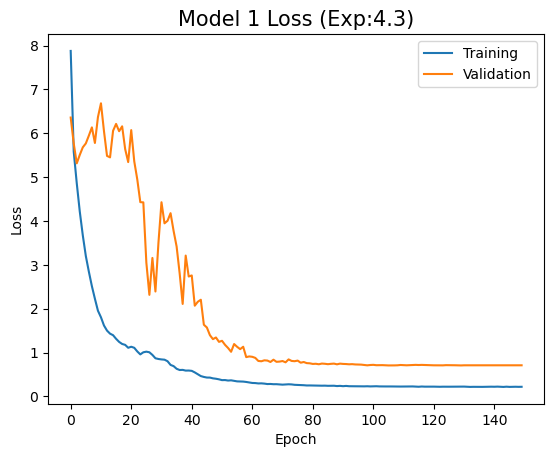

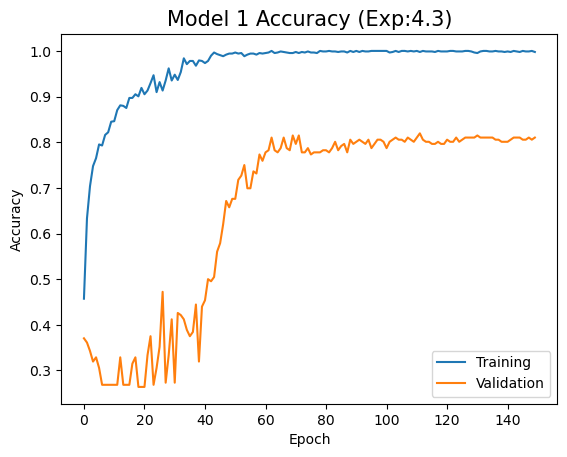

In [23]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:4.3)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:4.3)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:4.3)')

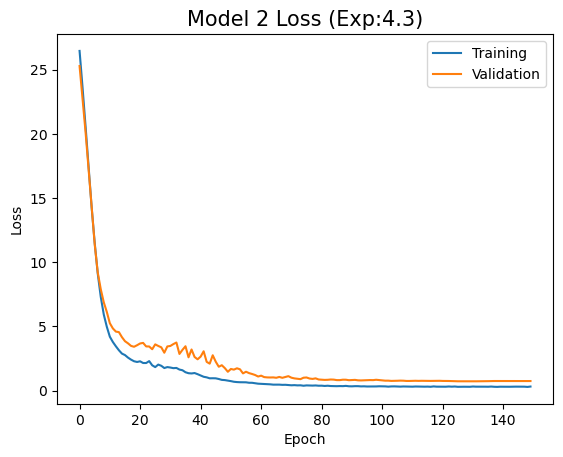

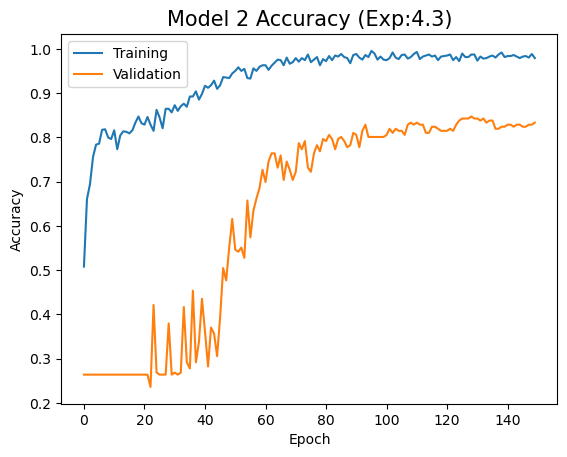

In [24]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:4.3)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:4.3)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:4.3)')

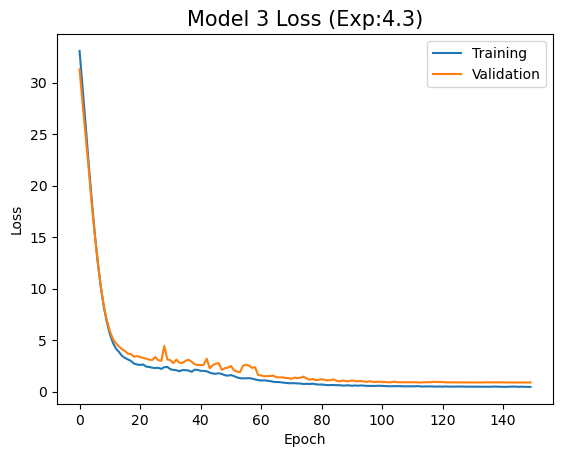

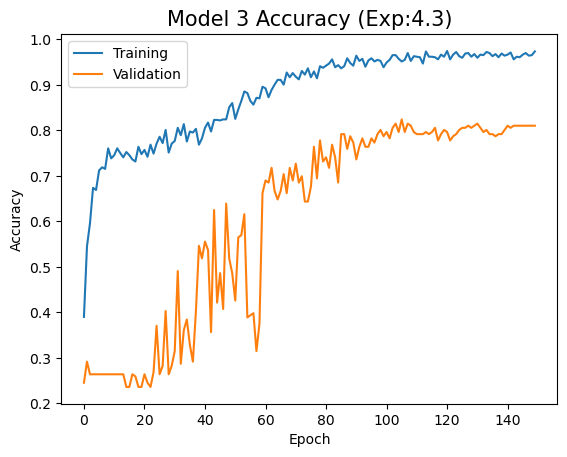

In [25]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:4.3)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:4.3)', fontsize = 15)

In [26]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7853 - loss: 0.7506
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8645 - loss: 0.6767
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8129 - loss: 0.8724


In [27]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


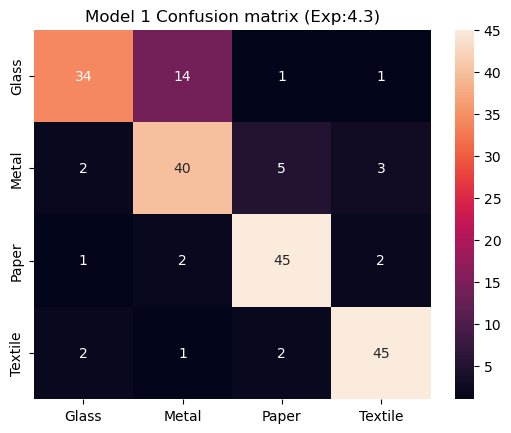

In [28]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sns.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:4.3)')
plt.show()

In [29]:
#Obtain the model's prediction for the test_images
predictions2 = model_2.predict(test_images)
pred_label2 = np.argmax(predictions2, axis = 1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


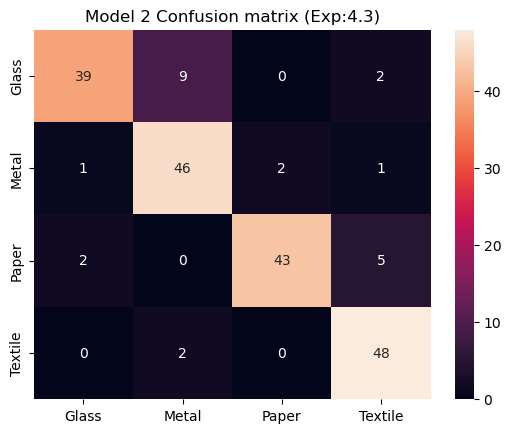

In [30]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:4.3)')
plt.show()

In [31]:
#Obtain the model's prediction for the test_images
predictions3 = model_3.predict(test_images)
pred_label3 = np.argmax(predictions3, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


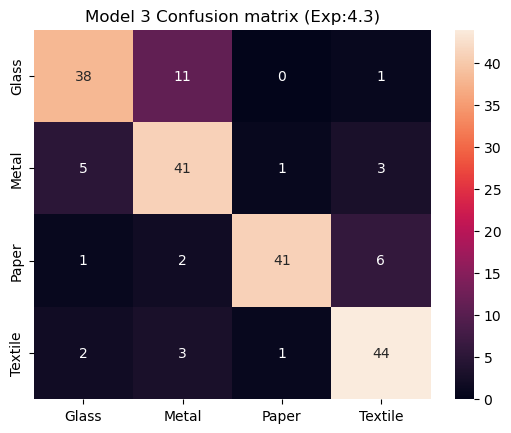

In [32]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sns.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:4.3)')
plt.show()